# Домашнее задание

1. Добиться хорошего результата от модели, собранной на занятии (6 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

2. *Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

# Дополнительные материалы
1. [Pytorch vs Tensorflow in 2020](https://towardsdatascience.com/pytorch-vs-tensorflow-in-2020-fe237862fae1)
2. [Официальная документация PyTorch](https://pytorch.org/tutorials/)

# Определения

**Вычислительный граф** — это иллюстрированная запись какой-либо функции, состоящая из вершин и рёбер. Вершины (или узлы) — вычислительные операции, которые необходимо выполнить, а рёбра связывают их в определённую последовательность.

Шаги обучения:
1. Проход по батчу
2. Обнуление градиента
3. Предсказание модели на батче
4. Подсчет ошибки
5. Подсчет градиентов
6. Шаг оптимизации
7. Логирование информации

### Решение.

In [1]:
import torch
import torchvision
from torch import nn 
from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch, torchvision
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
print(f"Поддерживается ли CUDA : {torch.cuda.is_available()}")
print(f'Количество гпу девайсов: {torch.cuda.device_count()}')
print(f"Переключение между гпу девайсами: {torch.cuda.device(0)}")
print(f"Характеристики видеокарты : {torch.cuda.get_device_properties(0)}")
print(f"Удаляем всю незанятую память через torch.cuda.empty_cache()")
# Что бы следующая команда работала вам нужно сделать pip install pynvml
print(f"Следующие процессы происходят на нашей гпу : \n{torch.cuda.list_gpu_processes()}")

Поддерживается ли CUDA : True
Количество гпу девайсов: 1
Переключение между гпу девайсами: <torch.cuda.device object at 0x7fac2c2606a0>
Характеристики видеокарты : _CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4042MB, multi_processor_count=6)
Удаляем всю незанятую память через torch.cuda.empty_cache()
Следующие процессы происходят на нашей гпу : 
pynvml module not found, please install pynvml


In [3]:
# укажем устройство на котором мы будем выполнять рассчеты.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Загрузка данных.

In [5]:
train_dataset = torchvision.datasets.CIFAR10(
    root='data/',  # путь, куда будут скачиваться данные(если download=true), 
                   # или где лежат данные(dowload=False)
    train=True,    # говорим что используем датасет для обучения  
    transform=transforms.ToTensor(), # преобразуем данные в формат тензоров
    download=True
)


image, label = train_dataset[0]
print(image.shape)
print(label)

Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [6]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 
           'frog', 'horse', 'ship', 'truck']

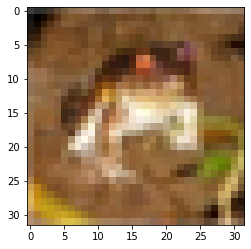

In [7]:
plt.imshow(image.permute(1, 2, 0));

## Даталоадер.

In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64, 
    shuffle=True
)

torch.Size([64, 3, 32, 32]) torch.Size([64])
plane


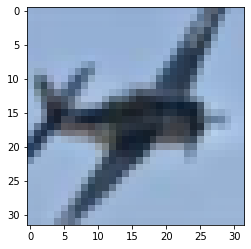

In [9]:
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)
    print(classes[labels[0]])
    plt.imshow(imgs[0].permute(1, 2, 0))
    break

In [10]:
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

Files already downloaded and verified


### Эксперименты с нейронными сетями

Сперва, возьмем нейронную сеть рассмотренную на уроке. 
Обучим ее. 

А, затем попробуем ее улучшить. 

In [11]:
# import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to('cuda')

In [12]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Цикл обучения нейронной сети

In [13]:
# %%time
def fit( model, train_loader, test_loader, loss_func, optimizer, num_epochs=10):
    train_loss = []
    testing_loss = []
    accuracy=[]
    for epoch in range(num_epochs):
        net.train()
        loss_sum=0
        for inputs, labels in tqdm(train_loader, ascii=True):
            inputs, labels = inputs.to(device), labels.to(device)

            # Делаем предсказание
            outputs = model(inputs)
            # Рассчитываем лосс-функцию
            loss = loss_func(outputs, labels)
            loss_sum +=loss.item()

            # Делаем шаг назад по лоссу
            loss.backward()
            # Делаем шаг нашего оптимайзера
            optimizer.step()
            # Обнуляем градиент
            optimizer.zero_grad()

            
       # выводим статистику о процессе обучения
        train_loss.append(loss_sum / len(train_loader))
    # =============================================================    
        net.eval()
        loss_sum=0
        num = 0 
        correct=0
        with torch.no_grad():
            for inputs, labels  in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Делаем предсказание
                outputs = model(inputs)
                # Рассчитываем лосс-функцию
                loss_sum += loss_func(outputs, labels).item()
                _, preds = torch.max(outputs, axis=-1)
                correct += (preds == labels).sum().item()
                num += len(inputs)

        testing_loss.append(loss_sum / len(test_loader))
        accuracy.append(correct/num)

        print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                f'loss: {train_loss[-1]:.4f} ' \
                f'val_loss: {testing_loss[-1]:.4f} ' \
                f'accuracy: {accuracy[-1]:.4f}')

    print('Training is finished!')
    return train_loss, testing_loss, accuracy

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
train_losses, valid_losses, accuracy =  fit(net, train_loader, test_loader, loss_func=criterion, optimizer=optimizer, num_epochs=15)

  0%|          | 0/782 [00:00<?, ?it/s]/home/sergey/anaconda3/envs/imageai_env/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|##########| 782/782 [00:09<00:00, 80.75it/s]
Epoch [1/15]. loss: 2.3025 val_loss: 2.3003 accuracy: 0.1286
100%|##########| 782/782 [00:09<00:00, 83.74it/s]
Epoch [2/15]. loss: 2.2954 val_loss: 2.2831 accuracy: 0.1313
100%|##########| 782/782 [00:14<00:00, 55.61it/s]
Epoch [3/15]. loss: 2.2158 val_loss: 2.1514 accuracy: 0.1982
100%|##########| 782/782 [00:13<00:00, 56.69it/s]
Epoch [4/15]. loss: 2.0529 val_loss: 1.8941 accuracy: 0.2971
100%|##########| 782/782 [00:13<00:00, 56.45it/s]
Epoch [5/15]. loss: 1.8208 val_los

In [16]:
def plot_trainig(train_losses, valid_losses,accuracy):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(accuracy, label="valid accuracy")
    plt.legend()

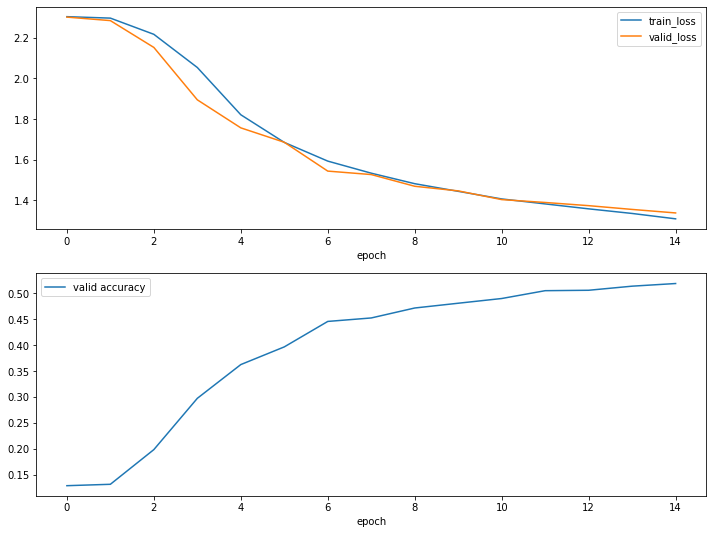

In [17]:
plot_trainig(train_losses, valid_losses, accuracy)

In [23]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

In [24]:
net.to('cpu')
outputs = net(images)

In [25]:
_, predicted = torch.max(outputs, 1)

predicted

gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'car' 'ship' 'frog' 'frog' 'car' 'bird']
Accuracy is 0.625


Попробуем немого повысить-во.

Изменим оптимизатор с SGD на Adam. И уменьшим learning rate. 

In [26]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [27]:
net.to('cuda')
train_losses, valid_losses, accuracy =  fit(net, train_loader, test_loader, loss_func=criterion, optimizer=optimizer, num_epochs=30)

100%|##########| 782/782 [00:16<00:00, 47.51it/s]
Epoch [1/30]. loss: 1.2653 val_loss: 1.2966 accuracy: 0.5386
100%|##########| 782/782 [00:16<00:00, 46.42it/s]
Epoch [2/30]. loss: 1.2473 val_loss: 1.2806 accuracy: 0.5431
100%|##########| 782/782 [00:10<00:00, 74.30it/s]
Epoch [3/30]. loss: 1.2312 val_loss: 1.2752 accuracy: 0.5429
100%|##########| 782/782 [00:12<00:00, 61.76it/s]
Epoch [4/30]. loss: 1.2171 val_loss: 1.2571 accuracy: 0.5515
100%|##########| 782/782 [00:15<00:00, 50.89it/s]
Epoch [5/30]. loss: 1.2020 val_loss: 1.2418 accuracy: 0.5608
100%|##########| 782/782 [00:16<00:00, 48.78it/s]
Epoch [6/30]. loss: 1.1876 val_loss: 1.2390 accuracy: 0.5635
100%|##########| 782/782 [00:17<00:00, 45.77it/s]
Epoch [7/30]. loss: 1.1750 val_loss: 1.2303 accuracy: 0.5664
100%|##########| 782/782 [00:17<00:00, 45.82it/s]
Epoch [8/30]. loss: 1.1613 val_loss: 1.2177 accuracy: 0.5696
100%|##########| 782/782 [00:24<00:00, 31.66it/s]
Epoch [9/30]. loss: 1.1492 val_loss: 1.2147 accuracy: 0.5696
1

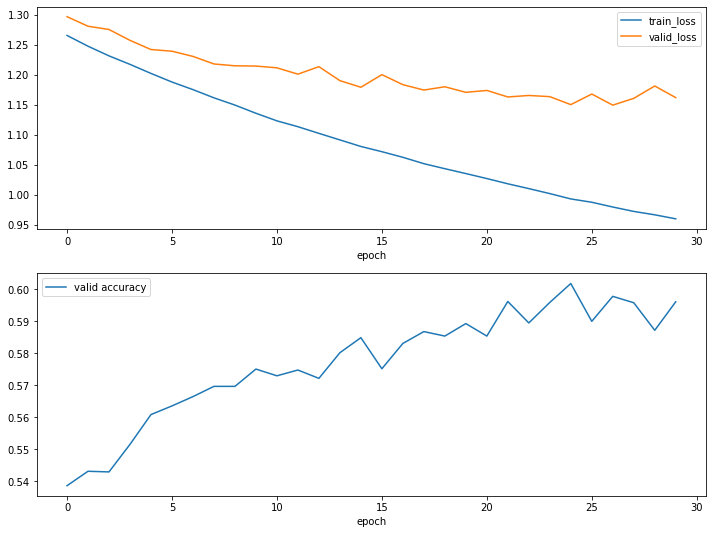

In [29]:
plot_trainig(train_losses, valid_losses, accuracy)

In [30]:
net.to('cpu')
outputs = net(images)

In [31]:
_, predicted = torch.max(outputs, 1)

predicted

gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'car' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
Accuracy is 0.875


### Идем дальше ==>

Попробуем еще повысить качество обучения. увеличив к-во сверточных слоев. И добавив нормализацию - BatchNorm2d.

In [32]:
k_size = 3
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=k_size,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=k_size,padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=k_size,padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=k_size,padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(in_features=4096, out_features=256)
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

# Где здесь указываются функции активации? 
# Где можно посмотреть 
# оптимизаторы.

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)),2))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.max_pool2d(F.relu(self.conv4(x)),2))
        x = x.view(x.size(0), -1)  #то так называемый Flatten слой, который Вы можете встретить в других библиотеках глубокого обучения. x.size(0) — это количество батчей. Остальное просто все распрямляется в единую форму данных. Например, если у вас было [1, 3, 254, 224], то станет [1, 7168].
        # x = x.reshape(-1, 16 * 5 * 5)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        # output = F.log_softmax(x, dim=1) # его использовать не надо т.к. он замедляет работу. Не используйте Softmax при классификации изображений — это существенно замедляет работу сети. Softmax встроен в CrossEntropyLoss.
        return x

net = Net().to('cuda')

In [33]:
net

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [34]:
# Оптимизатор.
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)

### Обучение нейронной сети.

In [35]:
train_losses, valid_losses, accuracy =  fit(net, train_loader, test_loader, loss_func=criterion, optimizer=optimizer, num_epochs=7)

100%|##########| 782/782 [00:20<00:00, 38.40it/s]
Epoch [1/7]. loss: 1.3089 val_loss: 0.9801 accuracy: 0.6512
100%|##########| 782/782 [00:17<00:00, 43.50it/s]
Epoch [2/7]. loss: 0.8906 val_loss: 0.8464 accuracy: 0.7063
100%|##########| 782/782 [00:14<00:00, 52.22it/s]
Epoch [3/7]. loss: 0.7336 val_loss: 0.7595 accuracy: 0.7362
100%|##########| 782/782 [00:18<00:00, 42.13it/s]
Epoch [4/7]. loss: 0.6181 val_loss: 0.7261 accuracy: 0.7488
100%|##########| 782/782 [00:18<00:00, 41.95it/s]
Epoch [5/7]. loss: 0.5177 val_loss: 0.7226 accuracy: 0.7526
100%|##########| 782/782 [00:18<00:00, 42.32it/s]
Epoch [6/7]. loss: 0.4252 val_loss: 0.7129 accuracy: 0.7601
100%|##########| 782/782 [00:17<00:00, 43.79it/s]
Epoch [7/7]. loss: 0.3426 val_loss: 0.7430 accuracy: 0.7559
Training is finished!


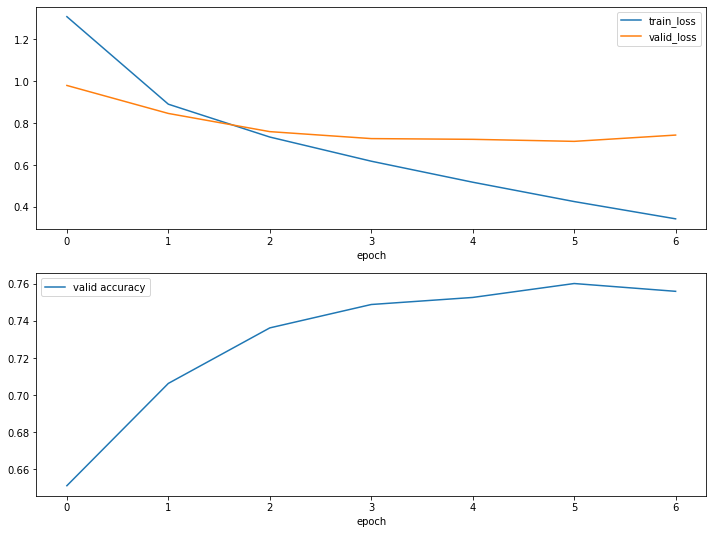

In [36]:
plot_trainig(train_losses, valid_losses, accuracy)

In [42]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

GroundTruth:  cat ship ship plane frog frog car frog


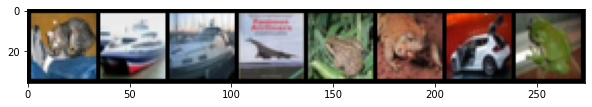

In [43]:
net.to('cpu')
outputs = net(images)

imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10,5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [44]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([3, 8, 8, 0, 6, 6, 1, 2])

In [45]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'bird']
Accuracy is 0.875


Видим что обученная нейронная сеть выдает к-во на примерно на 10% выше чем рассмотренная на уроке.